# 1. Importar librerias

In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
from geopandas import GeoDataFrame
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Point, LineString
import folium 
from folium import Marker, GeoJson
from folium.plugins import MarkerCluster, HeatMap
from matplotlib.colors import ListedColormap

# 2. Cargar y procesar datos

## 2.1. Corrupción real

In [3]:
contraloria_data           = pd.read_stata( r'../../input/built_data/c1.dta' )
vars_list                  = [ 'ubigeo', 'corrup_intensa', 'corrup_amplia', 'per_corrup1', 'per_corrup2', 'monto', 'year' ]
contraloria_data           = contraloria_data[ vars_list ]
contraloria_data[ 'year' ] = contraloria_data[ 'year' ].astype( str )

## 2.2. Corrupción predicha

In [4]:
predicted_data           = pd.read_csv( r'../../input/prediction_data/base0_ci/predicted_data/base0_complete.csv', dtype = { 'ubigeo': str, 'year': int }  )
predicted_data[ 'year' ] = predicted_data[ 'year' ].astype( str )

## 2.3. Shape file datos

In [5]:
shp_data = gpd.read_file( r'../../input/shape_file/DISTRITOS.shp' )
shp_data = shp_data.rename( columns = { 'IDDIST': 'ubigeo' } )
shp_data = shp_data[ [ 'ubigeo', 'geometry' ] ]

### 2.4. Merge

In [6]:
data_ = pd.merge( contraloria_data, 
                  predicted_data, 
                  on  = [ 'ubigeo', 'year' ],
                  how = 'right' )

In [7]:
years = data_[ 'year' ].unique()
data  = pd.DataFrame()

for year in years:
    data_year             = data_[ data_[ 'year' ] == year ]
    data_merged           = pd.merge( data_year, shp_data, on = 'ubigeo', how = 'right' )
    data_merged[ 'year' ] = year
    data                  = pd.concat( [ data, data_merged ] )

In [8]:
data[ 'corrup_intensa' ] = data[ 'corrup_intensa' ].map( { 'Sí': 'Corrupted', 'No': 'Not corrupted', np.NaN: 'Missing' } )
data[ 'corrup_amplia' ]  = data[ 'corrup_amplia' ].map( { 'Sí': 'Corrupted', 'No': 'Not corrupted', np.NaN: 'Missing' } )

data[ 'class_ci_default' ]       = data[ 'class_ci_default' ].map( { 1: 'Corrupted', 0: 'Not corrupted', np.nan: 'Missing' } )
data[ 'class_ci_calculated_70' ] = data[ 'class_ci_calculated_70' ].map( { 1: 'Corrupted', 0: 'Not corrupted', np.nan: 'Missing' } )
data[ 'class_ci_calculated_60' ] = data[ 'class_ci_calculated_60' ].map( { 1: 'Corrupted', 0: 'Not corrupted', np.nan: 'Missing' } )
data[ 'class_ci_calculated_50' ] = data[ 'class_ci_calculated_50' ].map( { 1: 'Corrupted', 0: 'Not corrupted', np.nan: 'Missing' } )
data[ 'class_ci_100' ]           = data[ 'class_ci_100' ].map( { 1: 'Corrupted', 0: 'Not corrupted', np.nan: 'Missing' } )

In [9]:
data = GeoDataFrame( data )

In [10]:
df_list = []

for year in years:
    df = data[ data[ 'year' ] == year ]
    df_list.append( df )

In [17]:
df_list[ 3 ][ 'class_ci_calculated_60' ].value_counts()

class_ci_calculated_60
Corrupted        1290
Not corrupted     597
Missing             7
Name: count, dtype: int64

# 3. Mapas de corrupción intensa

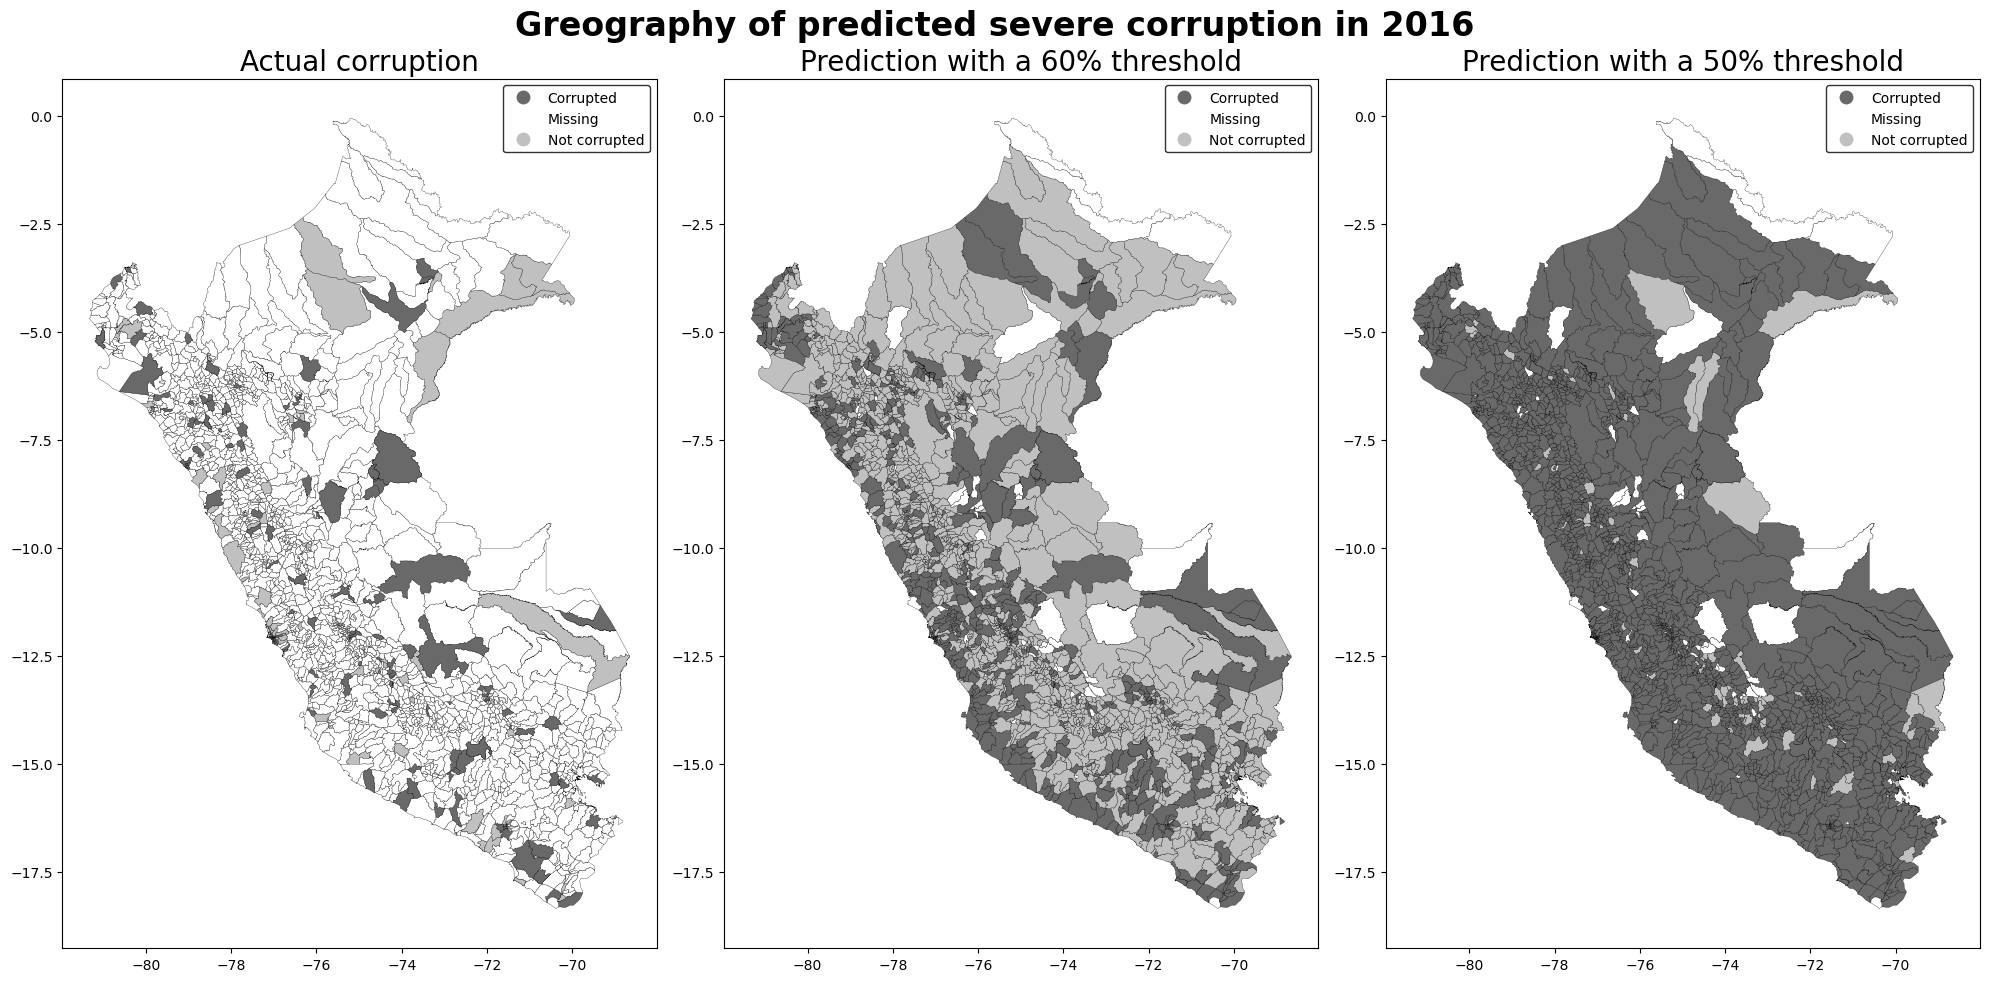

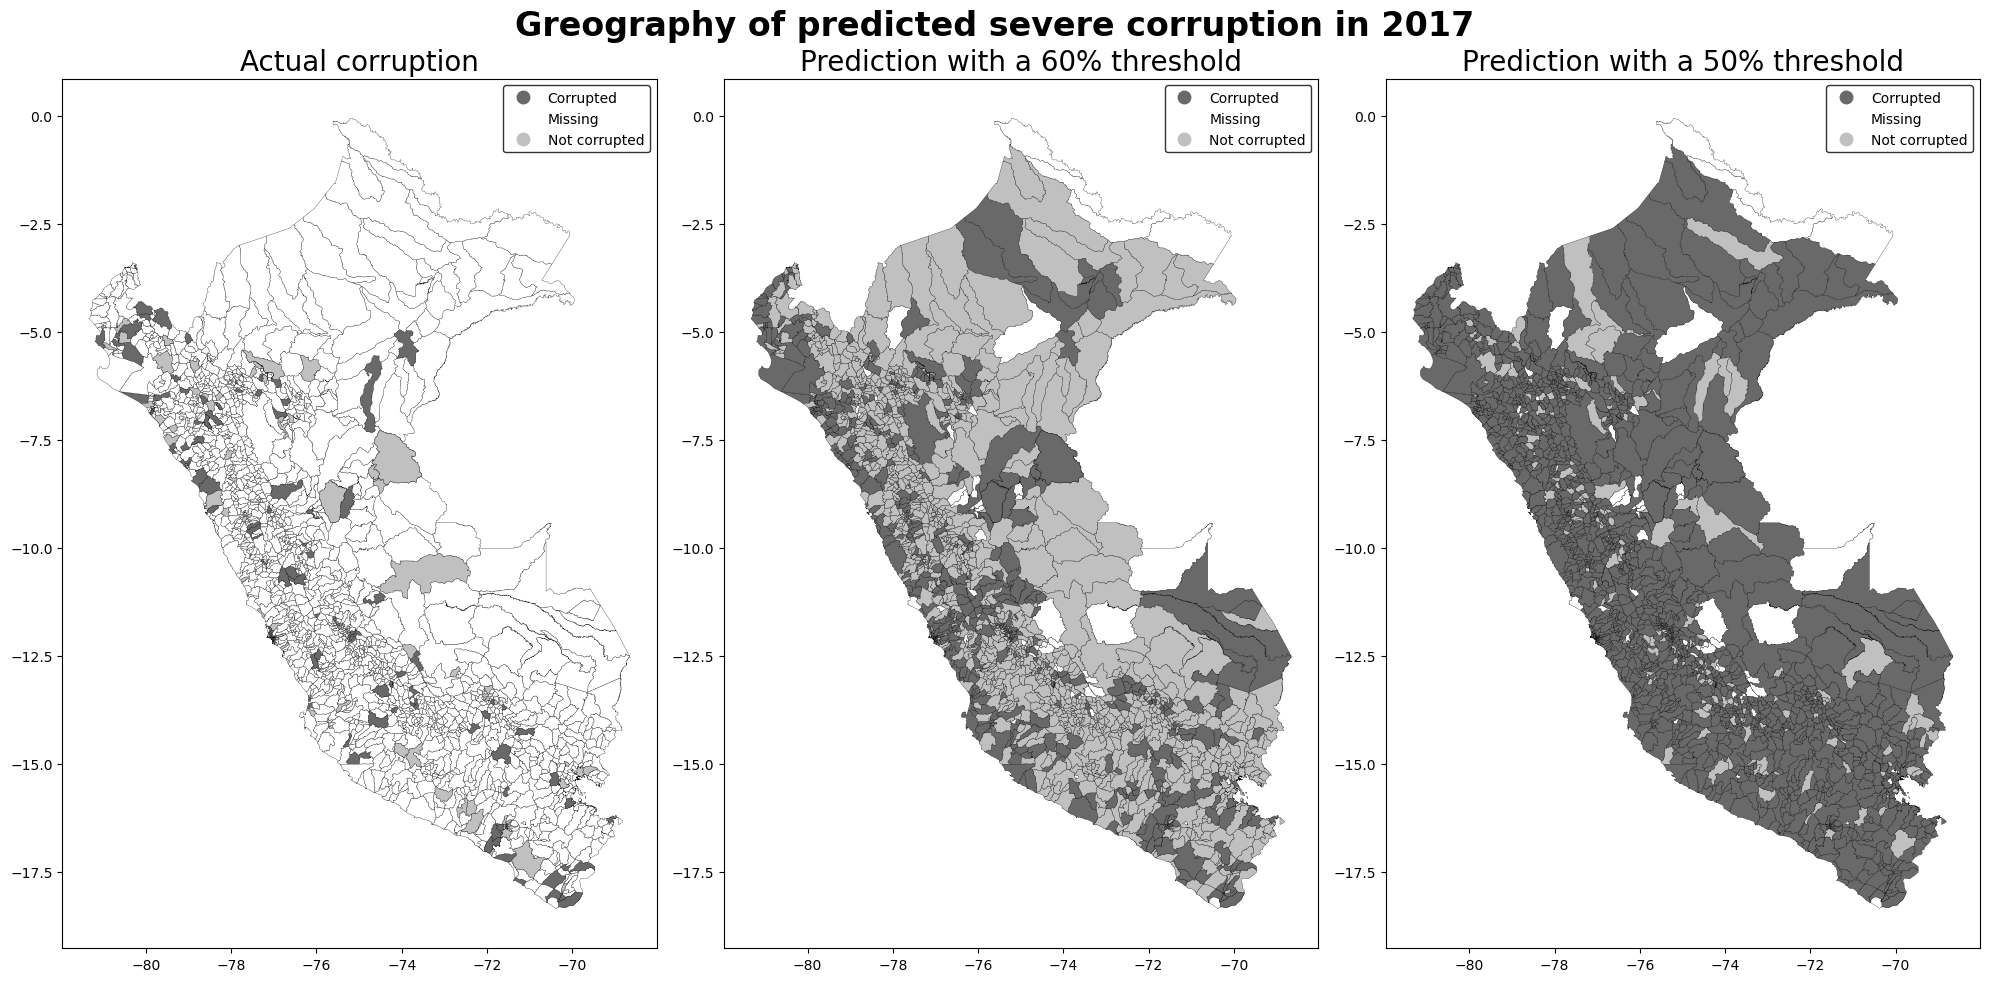

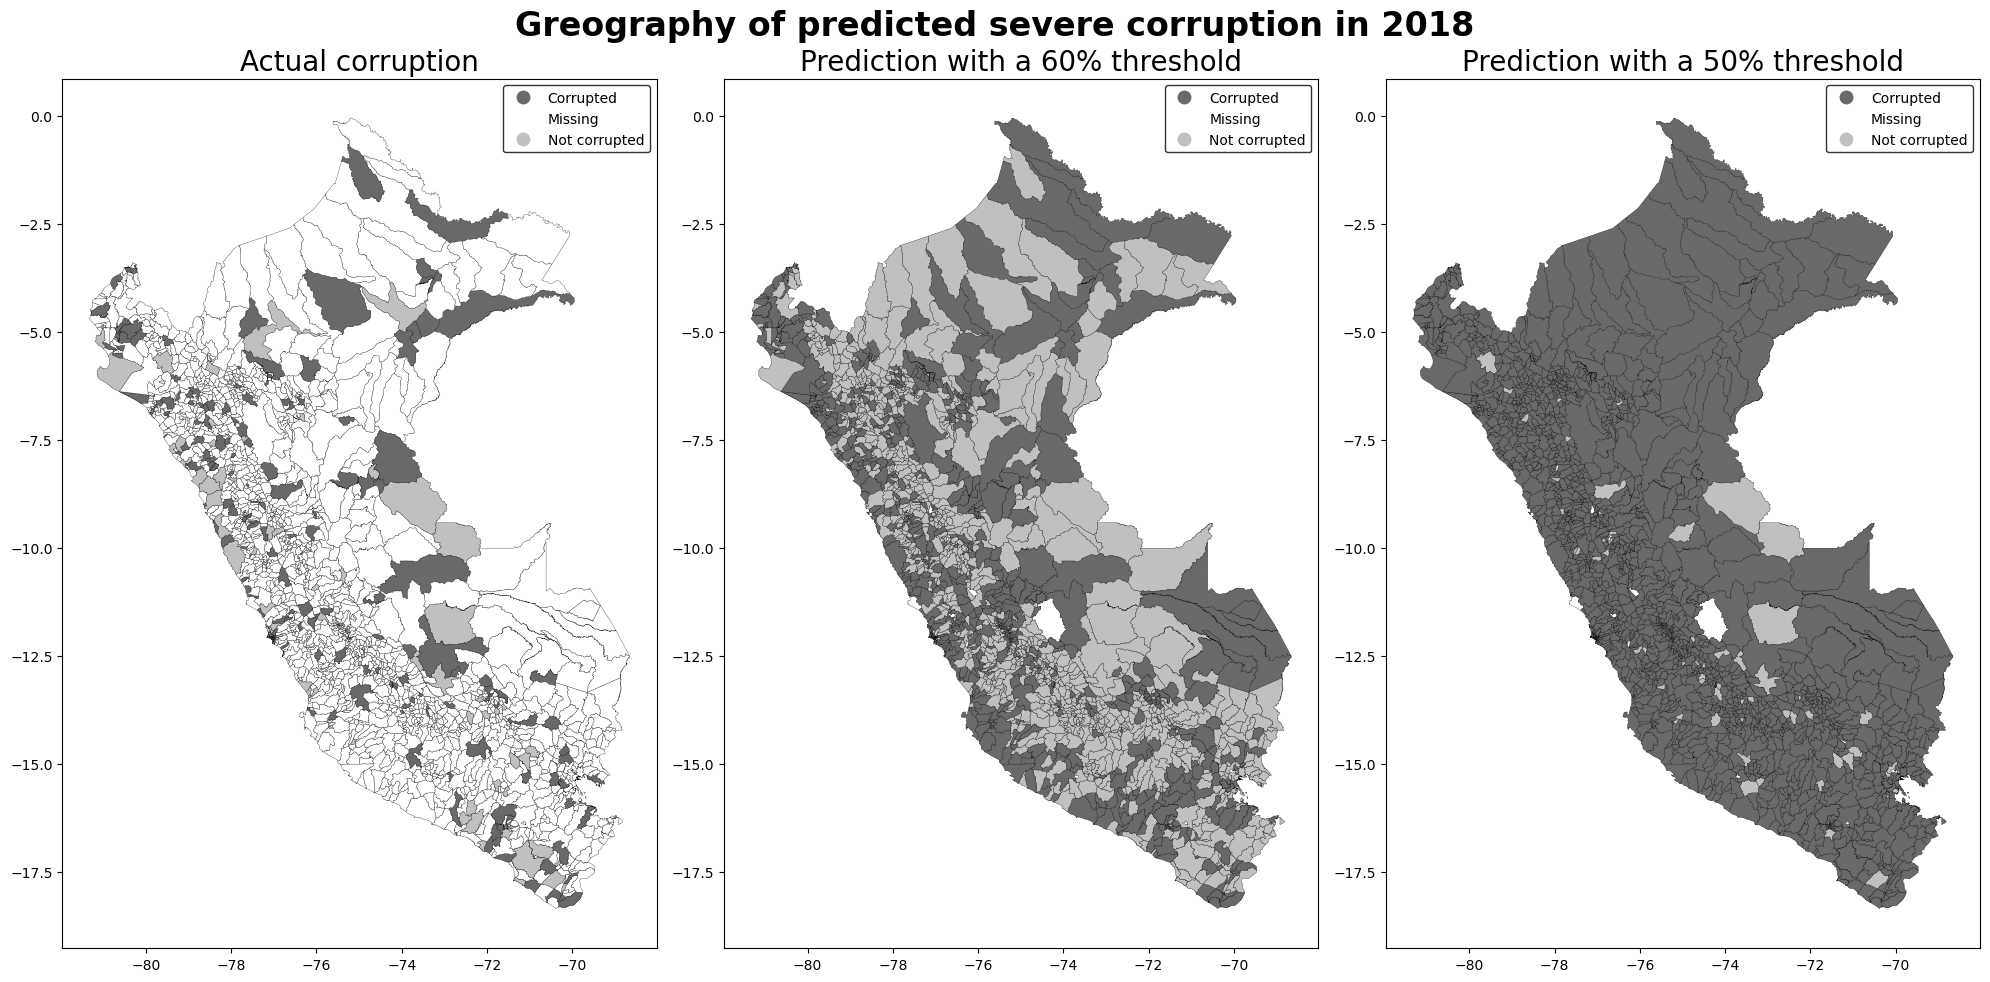

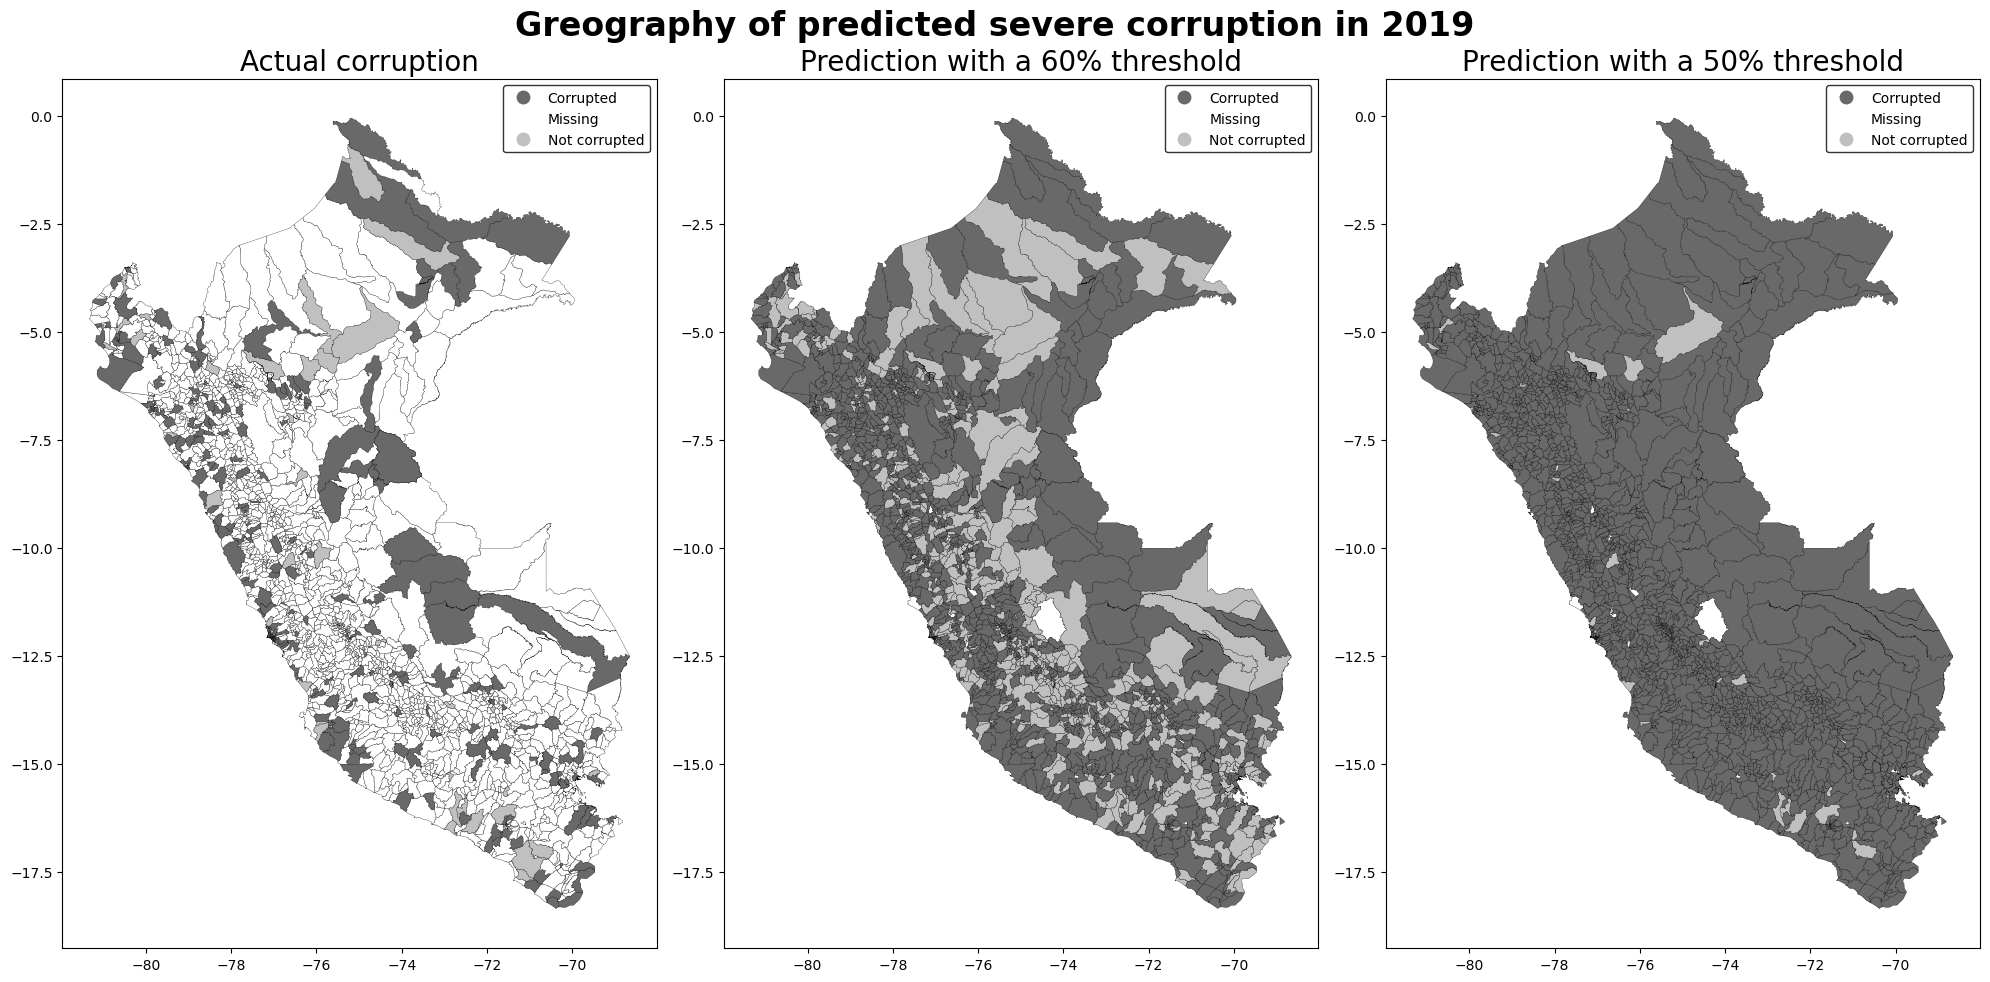

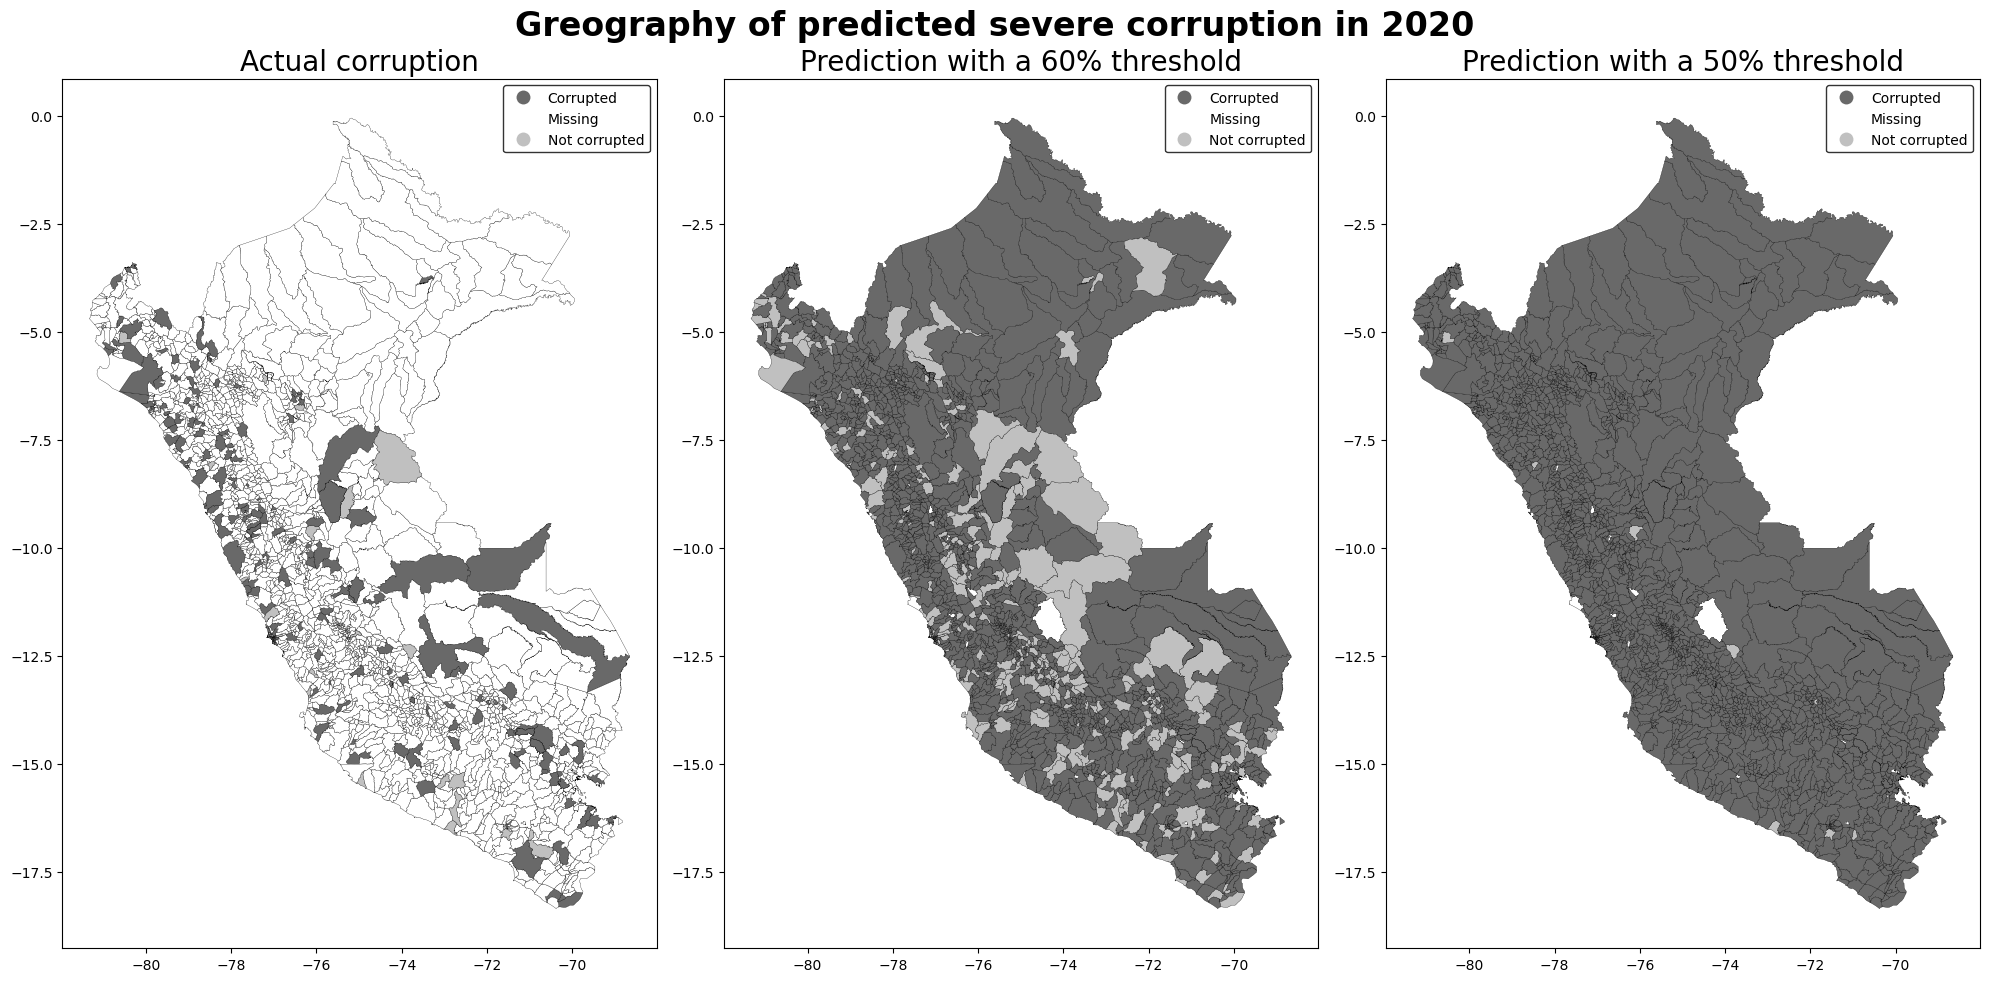

In [34]:
colores      = [ 'dimgray', 'white', 'silver' ]
cmap         = ListedColormap( colores )
subtittles   = [ 'Actual corruption', 'Prediction with a 60% threshold', 'Prediction with a 50% threshold' ]
vars_to_plot = [ 'corrup_intensa', 'class_ci_calculated_60', 'class_ci_calculated_50' ]

params = {          'cmap'         : cmap,    
                    'categorical'  : True,    
                    'linestyle'    : '-',
                    'edgecolor'    : 'black',
                    'legend'       : True,
                    'linewidth'    : 0.2,
                    'figsize'      : ( 20, 10 ),
                    'k'            : 3, 
                    'legend_kwds'  : { 
                                     'loc'       : 'upper right',
                                     'edgecolor' : 'black',
                                     'labelcolor': 'black'
                                    },
    
                    'missing_kwds' : {
                                     'color'    : 'lightgrey',
                                     'edgecolor': 'black',
                                     'linewidth': 0.2 
                                    }
         }

for index, df in enumerate( df_list ):
    
    index_to_year = { 0 : '2016', 1 : '2017', 2 : '2018', 3 : '2019', 4 : '2020' }
    year          = index_to_year.get( index )   

    fig, axes = plt.subplots( 1, 3, figsize=( 20, 10 ) )

    for i, var in enumerate( vars_to_plot ):

        df_list[ index ].plot( column = vars_to_plot[ i ], ax = axes[ i ], **params )
        axes[ i ].set_title( subtittles[ i ], fontsize = 20, loc = 'center' )
    
    plt.suptitle( f'Greography of predicted severe corruption in { year }', fontsize = 24, fontweight = 'bold' )
    plt.subplots_adjust(top = 1.2, bottom = 0.15, wspace = 0.2 )
    plt.tight_layout()
    plt.savefig( f'../../output/ejecucion_5/maps/b0_ci_{ year }.jpg', format = 'jpg', dpi = 300, bbox_inches = 'tight', pad_inches = 0.1 )